### Todo
- short time interval graph generation - done
- clean and improve data - done

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import geopandas as gpd
from shapely.geometry import Point
import pyproj
#pyproj.datadir.set_data_dir('/usr/local/share/proj')
from pyproj import CRS, Transformer
import folium

In [2]:
# this script is create by A. Biricz, ?.12.2020.
# Arguments:
# --source_folder
# --target_folder

# Add command line arguments

import numpy as np
import pandas as pd
from itertools import product
import os
from tqdm import tqdm
#from tqdm import tqdm_notebook as tqdm

# Locate files
source = '/media/Data_storage/Mobilcell/Data/'
target = '/media/Data_storage/Mobilcell/DayEventData/'
source_pol = '/media/Data_storage/Mobilcell/DayPolygonData/'

files_events = np.array( sorted([ i for i in os.listdir(source) if 'EVENTS' in i]) )
files_poligons = np.array( sorted([ i for i in os.listdir(source) if 'POLIGONS' in i]) )
files_events_cleaned = np.array( sorted([ i for i in os.listdir(source) if 'Events' in i]) )

In [3]:
files_poligons[129]

'MT_MTA_NETWORK_POLIGONS_20190409.csv.gz'

In [4]:
poligons_path = files_poligons[129]
events_path = files_events[129]

# load data
print("loading input data")
poligons_df = pd.read_csv( source+poligons_path, delimiter=';' )
events_df = pd.read_csv( source+events_path, delimiter=';' )

loading input data


/home/abiricz/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# drop poligons outside of the country
poligons_df = poligons_df[ np.logical_and( poligons_df.eovx.values < 366660, 
                                           poligons_df.eovx.values > 48210 ) ]
poligons_df = poligons_df[ np.logical_and( poligons_df.eovy.values < 934219, 
                                           poligons_df.eovy.values > 426341 ) ]

# load global, fix tower data
towers_df = pd.read_csv( source_pol+'fixed_merged_tower_locations.csv' )

# calculate tower encodings
tower_id = np.unique( towers_df.original_id.values )
tower_to_int = dict( zip( towers_df.original_id.tolist(), towers_df.tower_id.tolist() ) )

tower_coords_all = dict( zip( towers_df.values[:,1].tolist(), towers_df.values[:,2:4].tolist() ) )

# add encodings to the dataframes
print("encode ids of towers and events")
poligons_df["tower_idx"] = [ tower_to_int[i] for i in poligons_df.network_identifier.values ]
events_df["tower_idx"] = [ tower_to_int[i] for i in events_df.network_identifier.values ]

# calculate event (equipment id) encodings
event_id = np.unique( events_df.equipment_identifier.values )
event_to_int = dict(zip( event_id, np.arange(event_id.shape[0]) ))

# add event encodings to the dataframes
events_df["event_idx"] = [ event_to_int[i] for i in events_df.equipment_identifier.values ]

# partitioning the event dataframe to track individual events
eq_diff_idx = np.where( np.diff(events_df.event_idx.values) )[0]+1
# insert first element (zero) ## otherwise left out!
eq_diff_idx = np.insert(eq_diff_idx, 0, 0, axis=0)
# insert last element (size of array) ## otherwise left out!
eq_diff_idx = np.append( eq_diff_idx, events_df.event_idx.values.shape[0] )

encode ids of towers and events


In [6]:
# calculate trajectories of events (to which tower it connects to and when)
eq_trajectories_towers = []
eq_trajectories_time = []
print("calculate trajectories of events..")
for i in tqdm( range( eq_diff_idx.shape[0]-1 ) ):
    start_ = eq_diff_idx[i]
    end_ = eq_diff_idx[i+1]
    eq_trajectories_towers.append( events_df.tower_idx.values[ start_:end_ ] )
    eq_trajectories_time.append( events_df.event_datetime.values[ start_:end_ ] )

  0%|          | 18304/6274252 [00:00<01:08, 91182.01it/s]

calculate trajectories of events..


100%|██████████| 6274252/6274252 [01:08<00:00, 92022.10it/s]


In [7]:
# these arrays holds the information about the events
eq_trajectories_towers = np.array( eq_trajectories_towers ) # array of variable length arrays!
eq_trajectories_time = np.array( eq_trajectories_time ) # array of variable length arrays!

In [8]:
eq_trajectories_time.shape, eq_trajectories_towers.shape

((6274252,), (6274252,))

In [9]:
filt_only_one_signal = np.array( [ len(i) > 1 for i in eq_trajectories_towers ] )
eq_trajectories_towers = eq_trajectories_towers[ filt_only_one_signal ]
eq_trajectories_time = eq_trajectories_time[ filt_only_one_signal ]

In [10]:
eq_trajectories_time.shape, eq_trajectories_towers.shape

((6031847,), (6031847,))

In [12]:
# check for unique values and drop events that stand still for the whole day
#eq_trajectories_towers_uq = np.array([ np.shape(np.unique(i))[0] for i in eq_trajectories_towers ])
#eq_trajectories_time = eq_trajectories_time[ eq_trajectories_towers_uq > 1 ]
#eq_trajectories_towers = eq_trajectories_towers[ eq_trajectories_towers_uq > 1 ]

# load datetime variable to code time as minutes
dates_clock = np.loadtxt( "../Data/event_datetime.csv").astype(int) # time on clock
dates_time = np.arange( 1440 ) # time in sec
time_to_sec = dict( zip(dates_clock, dates_time) )

### Investigate how event trajectories can be improved

In [13]:
eq_trajectories_towers.shape

(6031847,)

In [14]:
eq_trajectories_towers[0]

array([9377, 9377, 9377, 9377, 9377, 9377, 9377, 9377, 9377, 9377])

In [15]:
eq_trajectories_time[0]

array([ 959, 1002, 1431, 1443, 1448, 1449, 1601, 1601, 2025, 2040])

In [16]:
max(tower_to_int.values()), len(tower_to_int.values())

(14584, 43376)

In [17]:
tower_datetime_events = np.zeros( ( max(tower_to_int.values())+1, dates_time.shape[0]), dtype=np.uint32 )
tower_datetime_events.shape

(14585, 1440)

In [18]:
eq_trajectories_time[1]

array([ 705,  849, 1036, 1036, 1041, 1041, 1154, 1209, 1209, 1209, 1209,
       1517, 1534, 1724, 1941])

In [19]:
## PART 1:
tower_datetime_events = np.zeros( ( max(tower_to_int.values())+1, dates_time.shape[0]), dtype=np.uint32 )

counter = 0
passed = 0
eps = 1e-6 # add small time to avoid division by zero
for curr in tqdm( range( eq_trajectories_time.shape[0] ) ):
    #print(curr)
    
    # get event time in minutes
    eq_time_ = np.array( list( map(time_to_sec.get, eq_trajectories_time[curr]) ) )
    
    ## filter if the time of the source and destination is the same
    eq_timestamps = np.vstack( (eq_time_[:-1], eq_time_[1:]) ).T
    filt = (eq_timestamps[:,0] != eq_timestamps[:,1])
    filt = np.insert( filt, 0, True )
    
    # events associated to a tower with its valid timestamp are here
    eq_time_ = eq_time_[filt]
    eq_tower = eq_trajectories_towers[curr][filt]
    #print(eq_time_.shape, eq_tower.shape)
    
    #print('here')
    
    ## do filtering with respect to speed
    eq_path = np.vstack( (eq_tower[:-1], eq_tower[1:]) ).T

    # get elapsed time
    eq_time_min = eq_time_[1:] - eq_time_[:-1]
    eq_time_min = eq_time_min / 60 # this becomes hour for calc speed!
    #filt = eq_time_min > 0.49 # here HARDCODED 30 minutes interval!
    #filt = np.insert( filt, 0, True )
    #print(filt)
    
    if eq_time_.shape[0] >= 2:

        # get coordinates of source and destination tower
        src_coords = np.array([ tower_coords_all[ m ] for m in eq_path[:,0] ])
        dst_coords = np.array([ tower_coords_all[ n ] for n in eq_path[:,1] ])

        # get distance
        eq_dist_km = np.sqrt( np.sum( ( dst_coords - src_coords )**2, 1 ) ) / 1000

        # get speed
        eq_speed_kmh = (eq_dist_km/eq_time_min+eps).astype(int)

        # filter high speed events
        filt = np.logical_and( eq_speed_kmh > -1, eq_speed_kmh < 180 )
        filt = np.insert( filt, 0, True )
        eq_time_ = eq_time_[filt]
        eq_tower = eq_tower[filt]
        #print(eq_time_, eq_tower )

        # register valid event
        #print(eq_time_.shape, eq_tower.shape)
        tower_datetime_events[ eq_tower, eq_time_ ] += 1
    else:
        passed += 1
    

100%|██████████| 6031847/6031847 [13:41<00:00, 7346.81it/s]


In [20]:
passed

255479

In [21]:
tower_datetime_events[:10,:10]

array([[2727,  127,  133,  126,  132,  107,  126,  142,  123,  119],
       [2461,   97,   81,   96,   93,   80,   77,   68,   82,   76],
       [ 825,   35,   22,   31,   41,   35,   34,   35,   39,   45],
       [ 889,   39,   38,   36,   34,   27,   43,   39,   37,   33],
       [   1,    0,    0,    0,    1,    0,    2,    0,    0,    0],
       [   9,    0,    0,    0,    0,    0,    0,    0,    0,    1],
       [ 566,   29,   21,   13,   30,   26,   19,   28,   30,   27],
       [ 501,   28,   32,   27,   30,   29,   22,   33,   27,   20],
       [ 649,   23,   22,   34,   20,   22,   25,   23,   24,   21],
       [ 426,   16,   28,   12,   21,   17,   18,   17,   20,   24]],
      dtype=uint32)

In [22]:
tower_datetime_events[:,450:480]

array([[1994,  464,  496, ...,  601,  633,  660],
       [2062,  538,  473, ...,  655,  627,  643],
       [ 693,  209,  188, ...,  234,  271,  253],
       ...,
       [  10,    5,    5, ...,    6,    1,    7],
       [  12,    2,    1, ...,    5,    3,    2],
       [  11,    4,    1, ...,    1,    6,    2]], dtype=uint32)

In [23]:
C = np.zeros( ( tower_datetime_events.shape[0], 2), dtype=np.uint32 )
C.shape

(14585, 2)

In [24]:
C[ list(tower_coords_all.keys()) ] = np.array( list( tower_coords_all.values() ) )
C.shape

(14585, 2)

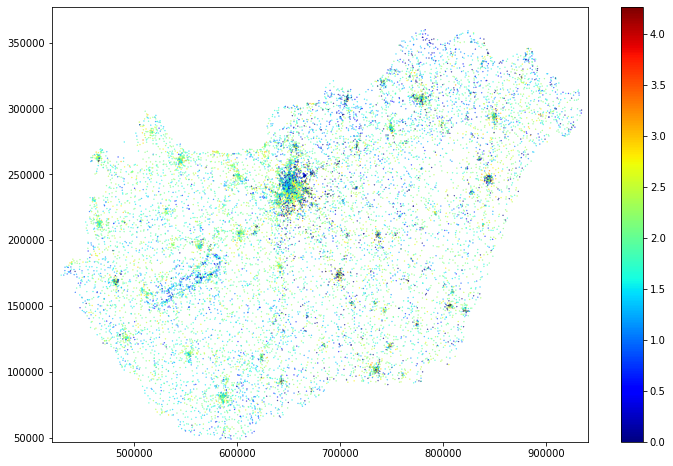

In [25]:
plt.figure( figsize=(12,8) )
cbar = plt.scatter( C[:,1], C[:,0],
             c=np.log10( np.sum( tower_datetime_events[:,450:480], axis=1 )+1 ), 
             cmap='jet', s=0.1 )
plt.xlim([420000, 940000])
plt.ylim([47000, 377000])
plt.colorbar( cbar )

(200000, 300000)

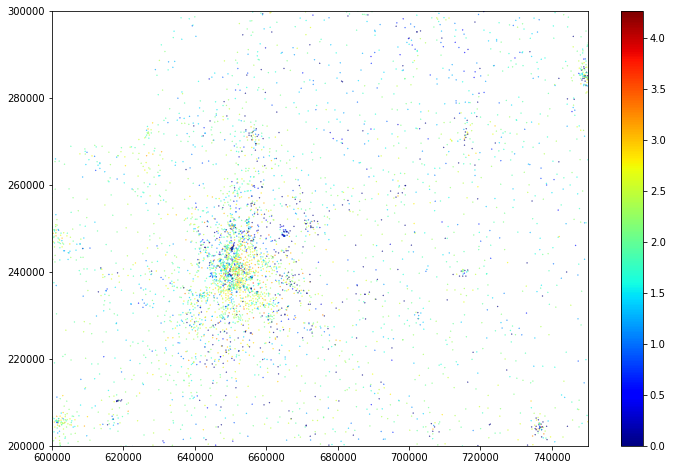

In [26]:
plt.figure( figsize=(12,8) )
cbar = plt.scatter( C[:,1], C[:,0],
             c=np.log10( np.sum( tower_datetime_events[:,450:480], axis=1 )+1 ), 
             cmap='jet', s=0.1 )
plt.colorbar( cbar )
plt.xlim([600000, 750000])
plt.ylim([200000, 300000])

In [27]:
crs_eov = CRS.from_epsg("23700")
crs_lonlat = CRS.from_epsg("4326")
transformer = Transformer.from_crs(crs_eov, crs_lonlat)

In [28]:
x_, y_ = transformer.transform( xx=C[:,1],
                                yy=C[:,0] )
x_.shape, y_.shape

((14585,), (14585,))

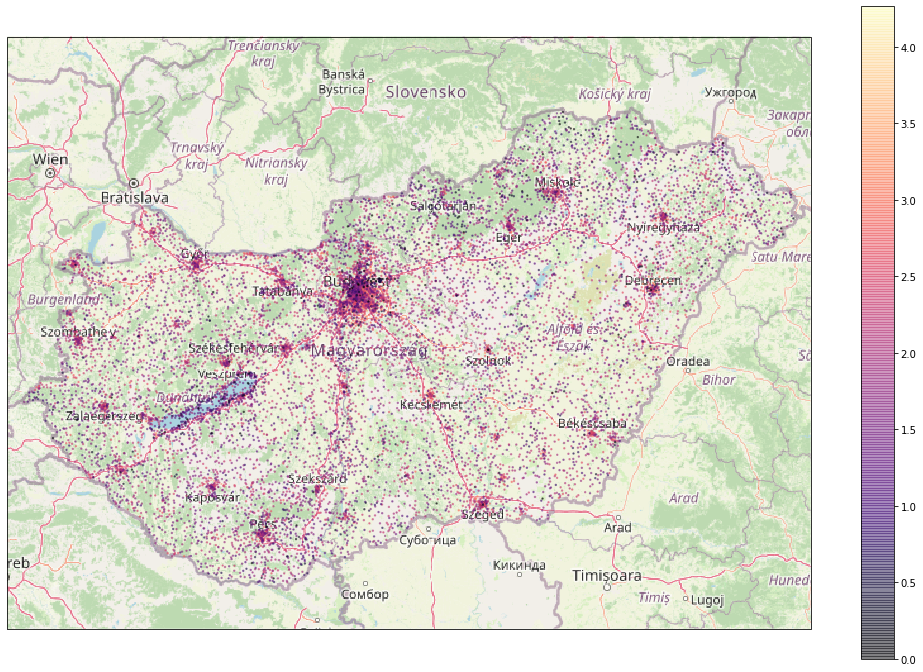

In [29]:
# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.OSM() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(18,12), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 8 is a layer num, higher means more detail

xynps = ax.projection.transform_points( ccrs.Geodetic(), 
                                        x=y_,
                                        y=x_ )

event_num = np.sum( tower_datetime_events[:,450:480], axis=1 ) 
filt_zeros = (event_num != 0)

X = xynps[:,0][filt_zeros]
Y = xynps[:,1][filt_zeros]
COL = np.log10(event_num[filt_zeros])

cbar = plt.scatter( X, Y, c=COL, cmap='magma', s=2, alpha=0.5 )
plt.colorbar( cbar )

#for i in range( xynps.shape[0] ):
#    plt.plot( xynps[i,0], xynps[i,1], alpha=0.1, color='midnightblue' )
#plt.savefig('motion_snapshot_30_minutes.png', dpi=100)

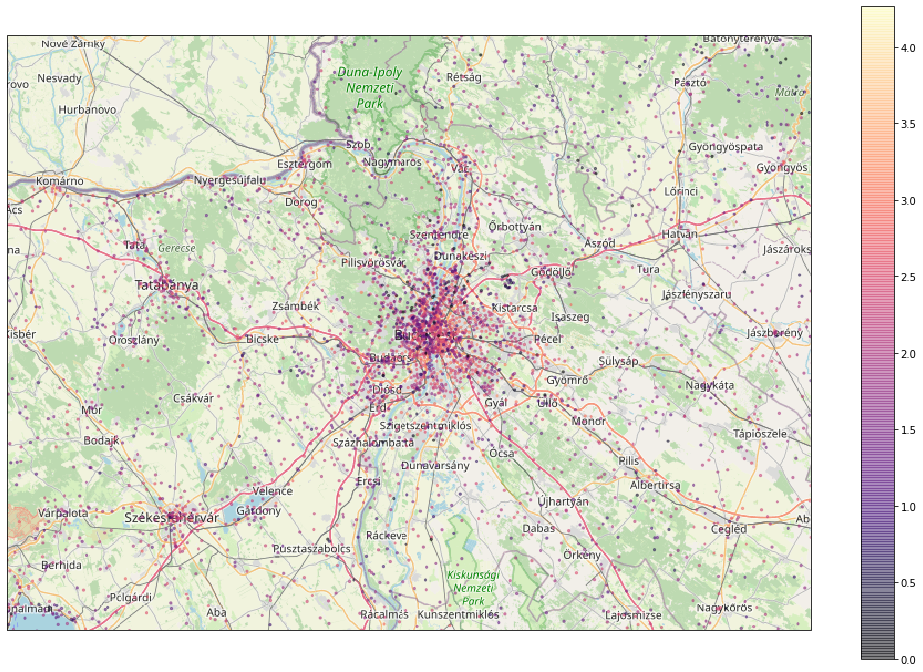

In [30]:
# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.OSM() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(18,12), subplot_kw=dict(projection=request.crs))
extent = [18, 20, 47, 48]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 9) # 8 is a layer num, higher means more detail

xynps = ax.projection.transform_points( ccrs.Geodetic(), 
                                        x=y_,
                                        y=x_ )

event_num = np.sum( tower_datetime_events[:,450:480], axis=1 ) 
filt_zeros = (event_num != 0)

X = xynps[:,0][filt_zeros]
Y = xynps[:,1][filt_zeros]
COL = np.log10(event_num[filt_zeros])

cbar = plt.scatter( X, Y, c=COL, cmap='magma', s=5, alpha=0.5 )
plt.colorbar( cbar )

#for i in range( xynps.shape[0] ):
#    plt.plot( xynps[i,0], xynps[i,1], alpha=0.1, color='midnightblue' )
#plt.savefig('motion_snapshot_30_minutes.png', dpi=100)

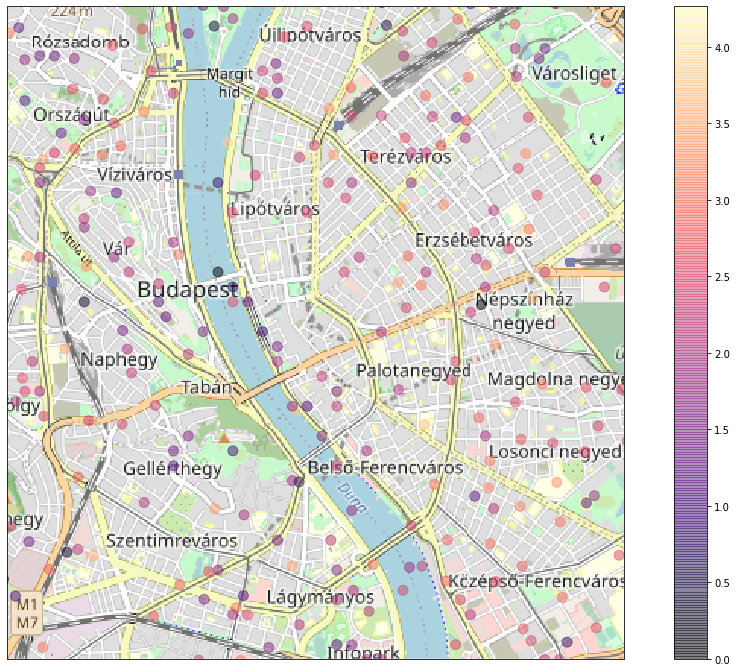

In [57]:
# https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background
request = cimgt.OSM() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(18,12), subplot_kw=dict(projection=request.crs))
extent = [19.02, 19.09, 47.47, 47.52]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 13) # 8 is a layer num, higher means more detail

xynps = ax.projection.transform_points( ccrs.Geodetic(), 
                                        x=y_,
                                        y=x_ )

event_num = np.sum( tower_datetime_events[:,450:480], axis=1 ) 
filt_zeros = (event_num != 0)

X = xynps[:,0][filt_zeros]
Y = xynps[:,1][filt_zeros]
COL = np.log10(event_num[filt_zeros])

cbar = plt.scatter( X, Y, c=COL, cmap='magma', s=100, alpha=0.5 )
plt.colorbar( cbar )

#for i in range( xynps.shape[0] ):
#    plt.plot( xynps[i,0], xynps[i,1], alpha=0.1, color='midnightblue' )
#plt.savefig('motion_snapshot_30_minutes.png', dpi=100)

In [32]:
event_num[filt_zeros].sum()

2370384

In [33]:
[19.02, 19.09, 47.47, 47.52]

[19.02, 19.09, 47.47, 47.52]

In [34]:
x_

array([47.49781597, 47.52823628, 47.50958125, ..., 46.57916844,
       46.56406667, 46.60924446])

In [35]:
x_filt = np.logical_and( x_ > 47.47, x_ < 47.52 )
x_filt = np.logical_and( y_ > 19.02, x_filt )
xy_filt = np.logical_and( y_ < 19.09, x_filt )
event_num_new = event_num[ xy_filt ]
event_num_new.sum()

135905

In [36]:
event_num_diff = np.sum( tower_datetime_events[:,450:480], axis=1 ).astype(np.int64) - np.sum( tower_datetime_events[:,480:510], axis=1 ).astype(np.int64) 

In [37]:
A = np.sum( tower_datetime_events[:,450:480], axis=1 ).astype(np.int64)

In [38]:
B = np.sum( tower_datetime_events[:,480:510], axis=1 ).astype(np.int64)

In [39]:
Z = np.subtract( A, B)
Z[:10]

array([-5326, -5225, -2862, -1757,   -73,     5,  -832,  -913,  -810,
       -1218])

In [40]:
A[:10]

array([17849, 18403,  7006,  5727,    39,    33,  4961,  4749,  4842,
        2864])

In [41]:
B[:10]

array([23175, 23628,  9868,  7484,   112,    28,  5793,  5662,  5652,
        4082])

In [42]:
Z[:10]

array([-5326, -5225, -2862, -1757,   -73,     5,  -832,  -913,  -810,
       -1218])

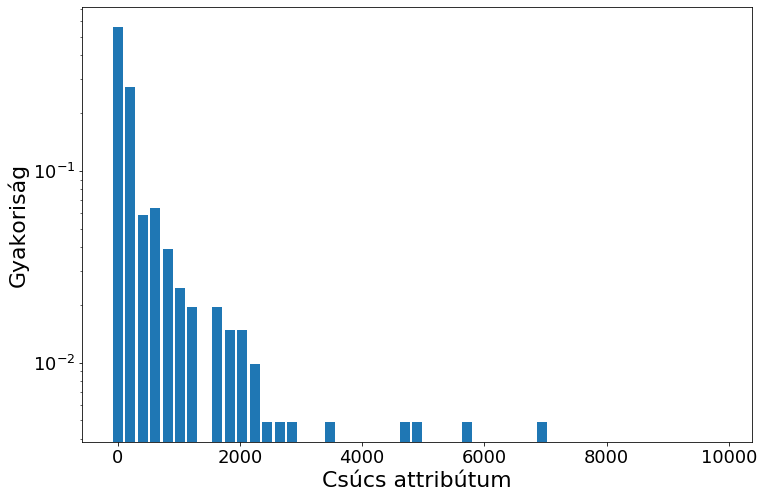

In [54]:
# https://stackoverflow.com/questions/37170511/scaled-logarithmic-binning-in-python
# log-scaled bins
plt.figure( figsize=(12,8) )
#bins = np.logspace(0, 3, 50)
bins = np.linspace(1, 1e4, 50)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
to_hist = event_num_new.flatten()
to_hist = to_hist[ to_hist > 0 ]
hist = np.histogram( to_hist, bins=bins)
# normalize by bin width
hist_norm = hist[0]/widths

# plot it!
plt.bar(bins[:-1], hist_norm, 0.8*widths)
#plt.xscale('log')
plt.yscale('log')

plt.ylabel('Gyakoriság', fontsize=22)
plt.xlabel('Csúcs attribútum', fontsize=22)
plt.tick_params( labelsize=18 )
plt.savefig('terkep_csucsattr_30min_Bp.png', dpi=100)

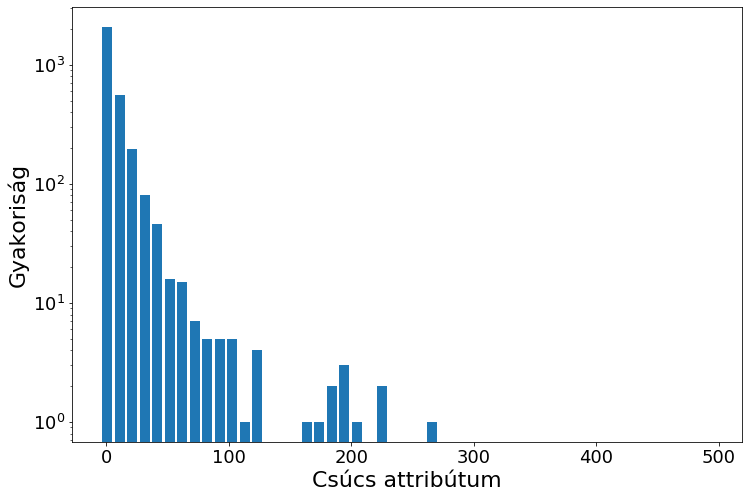

In [45]:
# https://stackoverflow.com/questions/37170511/scaled-logarithmic-binning-in-python
# log-scaled bins
plt.figure( figsize=(12,8) )
#bins = np.logspace(0, 3, 50)
bins = np.linspace(1, 500, 50)
widths = (bins[1:] - bins[:-1])

# Calculate histogram
to_hist = Z.flatten()
to_hist = to_hist[ to_hist > 0 ]
hist = np.histogram( to_hist, bins=bins)
# normalize by bin width
hist_norm = hist[0]#/widths

# plot it!
plt.bar(bins[:-1], hist_norm, 0.8*widths)
#plt.xscale('log')
plt.yscale('log')

plt.ylabel('Gyakoriság', fontsize=22)
plt.xlabel('Csúcs attribútum', fontsize=22)
plt.tick_params( labelsize=18 )
plt.savefig('terkep_csucsattr_30min_Bp.png', dpi=100)

In [51]:
( np.sum( tower_datetime_events[:,450:480], axis=1 ) == 0 ).sum()

7839

(array([7839.,  745.,  737.,  700.,  743.,  702.,  606.,  604.,  613.,
         601.,  560.,  528.,  527.,  527.,  477.,  508.,  463.,  453.,
         458.,  471.,  413.,  398.,  378.,  408.,  391.,  354.,  379.,
         348.,  351.,  372.,  336.,  293.,  342.,  306.,  324.,  286.,
         271.,  285.,  263.,  282.,  286.,  256.,  274.,  234.,  247.,
         234.,  258.,  244.,  264.,  204.,  235.,  239.,  228.,  197.,
         202.,  199.,  181.,  198.,  195.,  215.,  165.,  226.,  183.,
         171.,  185.,  210.,  171.,  152.,  175.,  156.,  187.,  167.,
         152.,  134.,  154.,  136.,  140.,  163.,  149.,  142.,  144.,
         130.,  146.,  120.,  143.,  134.,  123.,  123.,  112.,  103.,
         107.,  117.,  113.,   94.,  118.,  103.,   93.,  104.,  228.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4

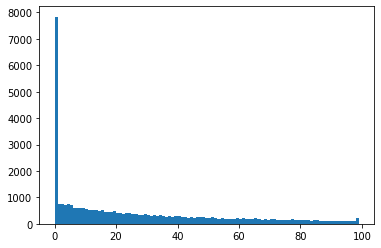

In [48]:
plt.hist( np.sum( tower_datetime_events[:,450:480], axis=1 ), np.arange(100) )